In [1]:
import pandas as pd

# Project Imports
from notebooks.consts import *
from notebooks.preprocessing import preprocess_aso_data

# Correlation Analysis
from notebooks.utils.correlation_test import analyze_feature_correlations

# Pandas Display Settings
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

In [2]:
# Load and preprocess the dataset
# This handles: Filtering Human, Dropping NaNs, Log Correction
all_data = preprocess_aso_data(UPDATED_CSV, include_smiles=False)

Preprocessing complete. Final valid rows: 29987


Preprocessing ASO Experimental Dataset

generate modification features

In [3]:
# compute_mod_fraction
from tauso.features.mod_features import compute_mod_fraction

all_data['Modification_fraction'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_fraction(x))
modification_features = ['Modification_fraction']

In [4]:
# compute_mod_type_count
from tauso.features.mod_features import compute_mod_type_count

all_data['Modification_type_count'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_type_count(x))
modification_features.append('Modification_type_count')

In [5]:
# compute_mod_5prime_run
from tauso.features.mod_features import compute_mod_5prime_run

all_data['Modification_5prime_run'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_5prime_run(x))
modification_features.append('Modification_5prime_run')

In [6]:
# compute_mod_3prime_run
from tauso.features.mod_features import compute_mod_3prime_run

all_data['Modification_3prime_run'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_3prime_run(x))
modification_features.append('Modification_3prime_run')

In [7]:
#compute_mod_min_distance_to_5prime
from tauso.features.mod_features import compute_mod_min_distance_to_5prime

all_data['Modification_min_distance_to_5prime'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_min_distance_to_5prime(x))
modification_features.append('Modification_min_distance_to_5prime')

In [8]:
#compute_mod_min_distance_to_3prime
from tauso.features.mod_features import compute_mod_min_distance_to_3prime

all_data['Modification_min_distance_to_3prime'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_min_distance_to_3prime(x))
modification_features.append('Modification_min_distance_to_3prime')

In [9]:
#compute_mod_pos_std
from tauso.features.mod_features import compute_mod_pos_std

all_data['Modification_pos_std'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_pos_std(x))
modification_features.append('Modification_pos_std')

In [10]:
#compute_mod_block_count
from tauso.features.mod_features import compute_mod_block_count

all_data['Modification_block_count'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_block_count(x))
modification_features.append('Modification_block_count')

In [11]:
#compute_mod_max_block_length
from tauso.features.mod_features import compute_mod_max_block_length

all_data['Modification_max_block_length'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_max_block_length(x))
modification_features.append('Modification_max_block_length')

In [12]:
#compute_mod_char_entropy
from tauso.features.mod_features import compute_mod_char_entropy

all_data['Modification_char_entropy'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_char_entropy(x))
modification_features.append('Modification_char_entropy')

In [13]:
#compute_dominant_mod_fraction
from tauso.features.mod_features import compute_dominant_mod_fraction

all_data['Modification_dominant_mod_fraction'] = all_data["Chemical_Pattern"].apply(lambda x: compute_dominant_mod_fraction(x))
modification_features.append('Modification_dominant_mod_fraction')

In [14]:
#compute_mod_evenness
from tauso.features.mod_features import compute_mod_evenness

all_data['Modification_evenness'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_evenness(x))
modification_features.append('Modification_evenness')

In [15]:
#compute_mod_symmetry_score
from tauso.features.mod_features import compute_mod_symmetry_score

all_data['Modification_symmetry_score'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_symmetry_score(x))
modification_features.append('Modification_symmetry_score')

In [16]:
#compute_mod_skew_index
from tauso.features.mod_features import compute_mod_skew_index

all_data['Modification_skew_index'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_skew_index(x))
modification_features.append('Modification_skew_index')

In [17]:
#compute_mod_mean_gap
from tauso.features.mod_features import compute_mod_mean_gap

all_data['Modification_mean_gap'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_mean_gap(x))
modification_features.append('Modification_mean_gap')

In [18]:
#compute_mod_local_density_max
from tauso.features.mod_features import compute_mod_local_density_max

all_data['Modification_local_density_max'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_local_density_max(x))
modification_features.append('Modification_local_density_max')

In [19]:
#compute_mod_in_core
from tauso.features.mod_features import compute_mod_in_core

all_data['Modification_in_core'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_in_core(x))
modification_features.append('Modification_in_core')

In [20]:
#compute_mod_longest_repeat_run
from tauso.features.mod_features import compute_mod_longest_repeat_run

all_data['Modification_longest_repeat_run'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_longest_repeat_run(x))
modification_features.append('Modification_longest_repeat_run')

In [21]:
#compute_mod_adjacent_pair_count
from tauso.features.mod_features import compute_mod_adjacent_pair_count

all_data['Modification_adjacent_pair_count'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_adjacent_pair_count(x))
modification_features.append('Modification_adjacent_pair_count')

In [22]:
#compute_mod_strong_repeat_group_count
from tauso.features.mod_features import compute_mod_strong_repeat_group_count

all_data['Modification_strong_repeat_group_count'] = all_data["Chemical_Pattern"].apply(lambda x: compute_mod_strong_repeat_group_count(x))
modification_features.append('Modification_strong_repeat_group_count')

In [23]:
from notebooks.utils.correlation_test import analyze_feature_correlations
results_df = analyze_feature_correlations(all_data, target='log_inhibition')
display(results_df)

/home/michael/career/tauso_article/tauso_source3/notebooks/utils/correlation_test.py:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/home/michael/career/tauso_article/tauso_source3/notebooks/utils/correlation_test.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)


,Feature,Pearson,Spearman,NMI_max
15,Inhibition(%),0.891,1.000,2.046
1,ISIS,-0.051,-0.129,0.152
0,index,0.340,0.325,0.114
20,Location_in_sequence,-0.022,0.204,0.108
26,sense_start,-0.027,0.199,0.108
6,ASO_volume(nM),0.305,0.325,0.094
34,Modification_pos_std,-0.228,-0.194,0.055
42,Modification_mean_gap,-0.275,-0.258,0.051
21,Location_div_by_length,0.056,0.103,0.045
28,Modification_fraction,0.179,0.191,0.035


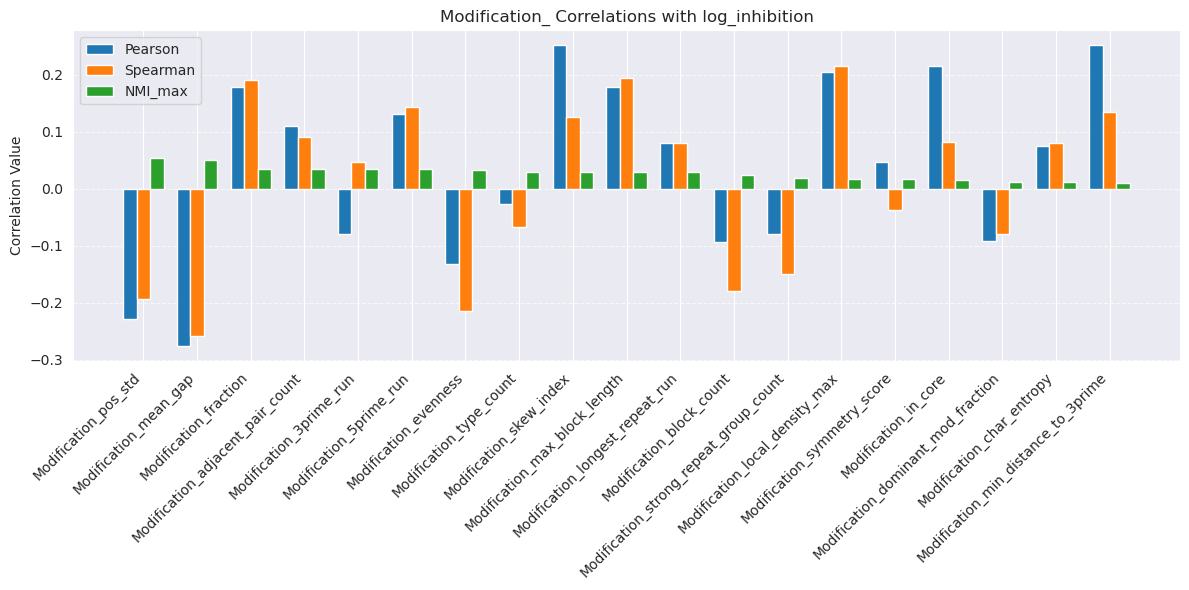

In [24]:
from notebooks.utils.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='Modification_', title='Modification_ Correlations with log_inhibition')

In [25]:
from notebooks.features.feature_extraction import save_feature
for feature in modification_features:
    save_feature(all_data, feature_name=feature)